# Visión por Computadora 2 - TP Final - Primera parte: EDA

**Integrantes:**
* Gustavo Ramoscelli
* Martín Errázquin

**Objetivo:** Clasificación de enfermedades en hojas de plantas.

**Dataset a utilizar:** [PlantVillage Dataset](https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset/data). Como consiste en 3 subcarpetas (color, grayscale, segmented) las cuales son imágenes originales, versión en escala de grises y versión con fondo eliminado se decidió trabajar solamente con la versión a color, que son las originales. Se consideró que de las tres opciones, esta es la más aplicable a un caso de uso real al no disponer del algoritmo utilizado para la segmentación.

## Imports

In [1]:
# install dependencies
# %pip install kagglehub
# %pip install --upgrade ipywidgets

import cv2
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import shutil
import torch
import torchvision.models as models
import torchvision.transforms as T
import zipfile
from collections import Counter, defaultdict
from pathlib import Path
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm

In [2]:


dataset = "abdallahalidev/plantvillage-dataset"
local_dir = Path("plantvillage-dataset")

if not local_dir.exists():
    print("Downloading dataset for the first time…")
    # this returns the path to your kagglehub cache
    cached_path = kagglehub.dataset_download(dataset)
    # copy everything into your own folder
    shutil.copytree(cached_path, local_dir)
    print(f"Copied into {local_dir!r}")
else:
    print(f"Dataset already present in {local_dir!r}, skipping download.")

print("Path to dataset files:", local_dir.resolve())


Dataset already present in PosixPath('plantvillage-dataset'), skipping download.
Path to dataset files: /home/gustavo/EDA_VpC2/plantvillage-dataset


In [3]:
# remove the top-level directory created by kagglehub because it has a space in its name
!mv ./{local_dir}/plantvillage\ dataset/* ./{local_dir}  2>/dev/null || true
!rmdir ./{local_dir}/plantvillage\ dataset  2>/dev/null || true

# change files extension to lowecase
for file in local_dir.rglob("*.*"):
    if file.suffix.lower() != file.suffix:
        new_file = file.with_suffix(file.suffix.lower())
        file.rename(new_file)

Counter({'segmented': 54306, 'grayscale': 54303, 'color': 54303})


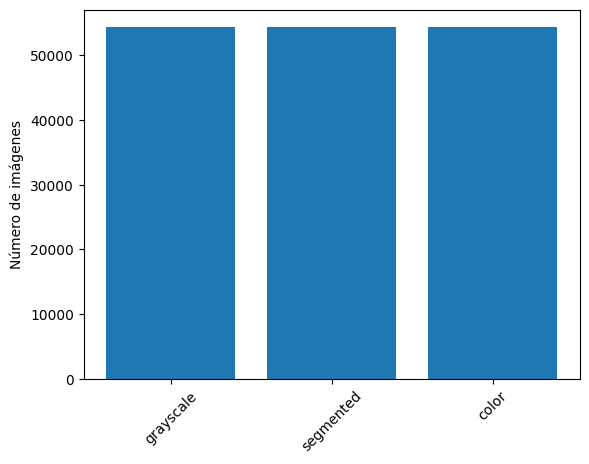

In [4]:
counts = Counter()
for cls_dir in local_dir.iterdir():
    if cls_dir.is_dir():
        img_files = [p for p in cls_dir.rglob("*.jpg")]
        n = len(img_files)  # ajusta la extensión si es necesario
        counts[cls_dir.name] = n

# Imprime y grafica
print(counts)

plt.bar(counts.keys(), counts.values())
plt.ylabel("Número de imágenes")
plt.xticks(rotation=45)
plt.show()


**Algunas muestras aleatorias**

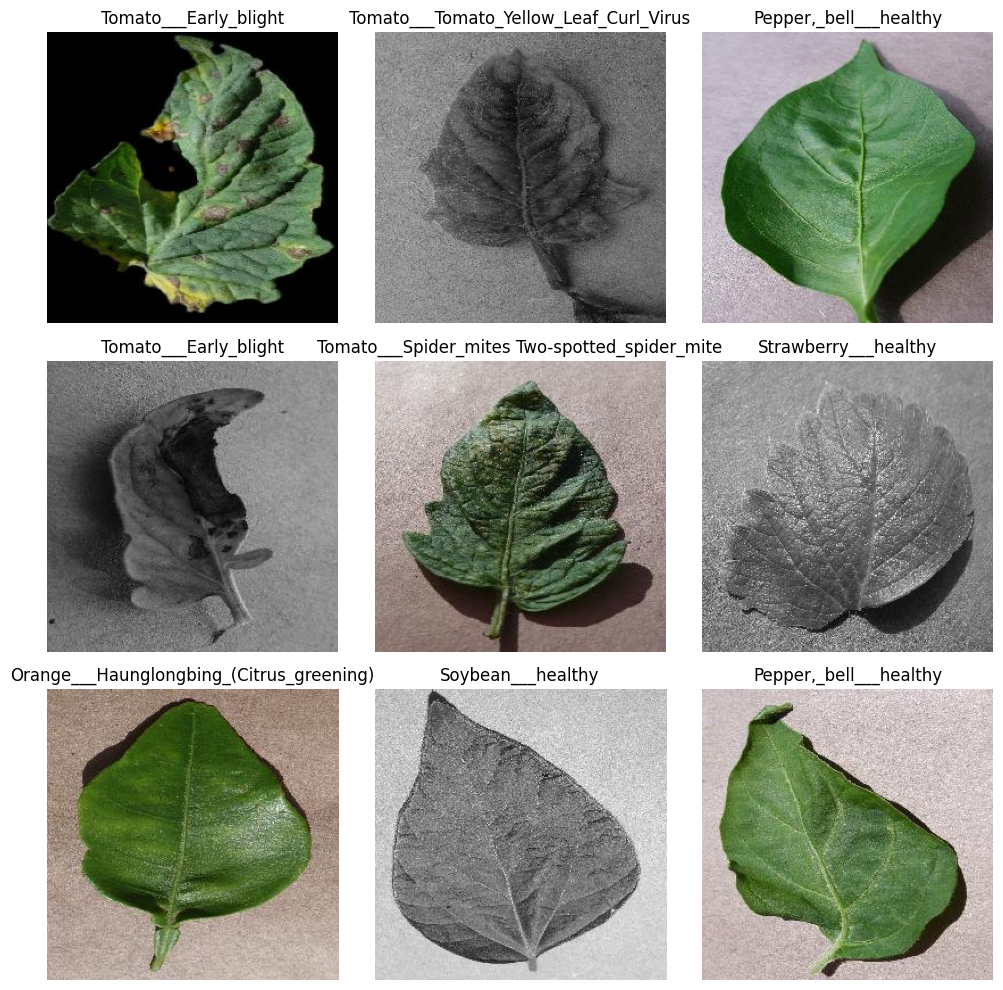

In [5]:
def show_random_samples(n=9):
    fig, axes = plt.subplots(int(n**0.5), int(n**0.5), figsize=(10,10))
    axes = axes.flatten()
    all_files = list(local_dir.rglob("*.jpg"))
    samples = random.sample(all_files, n)
    for ax, img_path in zip(axes, samples):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(img_path.parent.name)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

show_random_samples(9)

## Creación de un dataframe para facilitar la exploración del dataset

In [6]:
IMGS_DIR = local_dir / "color"
folder_df = pd.DataFrame([
    {'name': p.name, 'folder': str(p.parent), 'n_imgs': len(list(p.iterdir()))}
    for p in IMGS_DIR.iterdir()
]).sort_values('name').reset_index(drop=True)

folder_df

,name,folder,n_imgs
0,Apple___Apple_scab,plantvillage-dataset/color,630
1,Apple___Black_rot,plantvillage-dataset/color,621
2,Apple___Cedar_apple_rust,plantvillage-dataset/color,275
3,Apple___healthy,plantvillage-dataset/color,1645
4,Blueberry___healthy,plantvillage-dataset/color,1502
5,Cherry_(including_sour)___Powdery_mildew,plantvillage-dataset/color,1052
6,Cherry_(including_sour)___healthy,plantvillage-dataset/color,854
7,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,plantvillage-dataset/color,513
8,Corn_(maize)___Common_rust_,plantvillage-dataset/color,1192
9,Corn_(maize)___Northern_Leaf_Blight,plantvillage-dataset/color,985


Observar que la estructura del dataset es

* 'color'
    * fruta__clase_1
        * img1
        * img2
        * ...
    * fruta__clase_2
        * img3
        * ...
    * ...
    * fruta__clase_n
        * img4
        * ...

In [7]:
folder_df[['fruit','disease']] = folder_df['name'].str.split('___', regex=False, expand=True)

folder_df.filter(items=['fruit', 'disease', 'n_imgs'], axis=1)

,fruit,disease,n_imgs
0,Apple,Apple_scab,630
1,Apple,Black_rot,621
2,Apple,Cedar_apple_rust,275
3,Apple,healthy,1645
4,Blueberry,healthy,1502
5,Cherry_(including_sour),Powdery_mildew,1052
6,Cherry_(including_sour),healthy,854
7,Corn_(maize),Cercospora_leaf_spot Gray_leaf_spot,513
8,Corn_(maize),Common_rust_,1192
9,Corn_(maize),Northern_Leaf_Blight,985


In [8]:
# descripción a grandes rasgos de la cantidad de imágenes por clase
folder_df.describe()

,n_imgs
count,38.000000
mean,1429.078947
std,1271.738784
min,152.000000
25%,686.000000
50%,1092.500000
75%,1631.500000
max,5507.000000


In [9]:
# cantidad total de imágenes
folder_df.n_imgs.sum().item()

54305

In [10]:
# algunas descripciones por fruta
(
    folder_df
    .groupby('fruit')
    .agg({'n_imgs':'describe','disease':'first'})
    .reset_index()
)

fruit n_imgs                                             \
                             count         mean          std     min      25%   
0                     Apple    4.0   792.750000   591.715233   275.0   534.50   
1                 Blueberry    1.0  1502.000000          NaN  1502.0  1502.00   
2   Cherry_(including_sour)    2.0   953.000000   140.007143   854.0   903.50   
3              Corn_(maize)    4.0   963.000000   313.595281   513.0   867.00   
4                     Grape    4.0  1015.500000   415.063449   423.0   912.75   
5                    Orange    1.0  5507.000000          NaN  5507.0  5507.00   
6                     Peach    2.0  1328.500000  1369.665835   360.0   844.25   
7              Pepper,_bell    2.0  1237.500000   340.118362   997.0  1117.25   
8                    Potato    3.0   717.333333   489.593028   152.0   576.00   
9                 Raspberry    1.0   371.000000          NaN   371.0   371.00   
10                  Soybean    1.0  5090.000000          NaN  5090.0  5090.00   
11                   Squash    1.0  1835.000000          NaN  1835.0  1835.00   
12               Strawberry    2.0   782.500000   461.740728   456.0   619.25   
13                   Tomato   10.0  1816.000000  1349.100359   373.0  1101.00   

                                                         disease  
       50%      75%     max                              disease  
0    625.5   883.75  1645.0                           Apple_scab  
1   1502.0  1502.00  1502.0                              healthy  
2    953.0  1002.50  1052.0                       Powdery_mildew  
3   1073.5  1169.50  1192.0  Cercospora_leaf_spot Gray_leaf_spot  
4   1128.0  1230.75  1383.0                            Black_rot  
5   5507.0  5507.00  5507.0      Haunglongbing_(Citrus_greening)  
6   1328.5  1812.75  2297.0                       Bacterial_spot  
7   1237.5  1357.75  1478.0                       Bacterial_spot  
8   1000.0  1000.00  1000.0                         Early_blight  
9    371.0   371.00   371.0                              healthy  
10  5090.0  5090.00  5090.0                              healthy  
11  1835.0  1835.00  1835.0                       Powdery_mildew  
12   782.5   945.75  1109.0                          Leaf_scorch  
13  1633.5  1874.50  5357.0                       Bacterial_spot

Se puede observar que:

* Hay 54305 imágenes en total.
* Hay 38 clases en total.
* Las carpetas tienen entre 152 y 5507 imágenes, lo cual indica un fuerte desbalance entre las mismas.
* Hay 14 frutas en total.
* También hay un fuerte desbalance entre frutas, por ejemplo tomate tiene ~18k imágenes mientras que la frambuesa (raspberry) tiene 371.
* La cantidad de clases por fruta varía. Algunas tienen 1 sola clase, y en algunos casos ni siquiera es la clase 'sana' ('healthy') como es el caso de la calabaza ('Squash') o la naranja.

## 1. Análisis de distribución de colores

ANÁLISIS DE DISTRIBUCIÓN DE COLORES
 Dataset: 54303 imágenes totales
 Analizando muestra de: 30 imágenes


Cargando imágenes:   0%|          | 0/30 [00:00<?, ?it/s]

Se cargaron 30 imágenes de 54303 totales

 Analizando distribución RGB...


Analizando RGB:   0%|          | 0/30 [00:00<?, ?it/s]

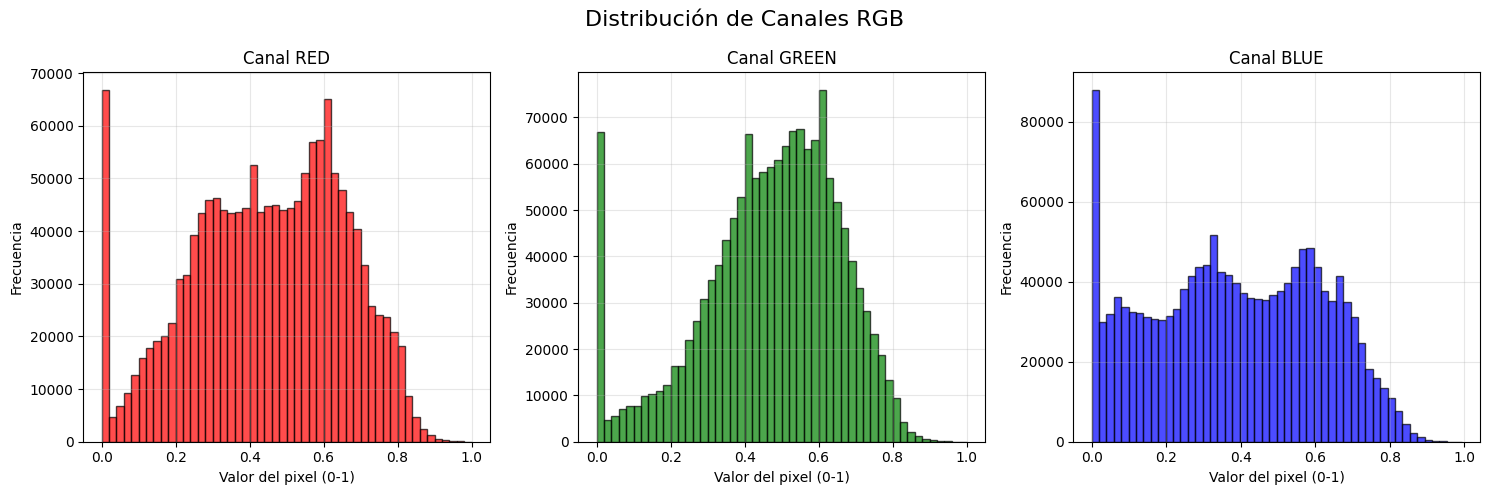


 Analizando distribución HSV...


Analizando HSV:   0%|          | 0/30 [00:00<?, ?it/s]

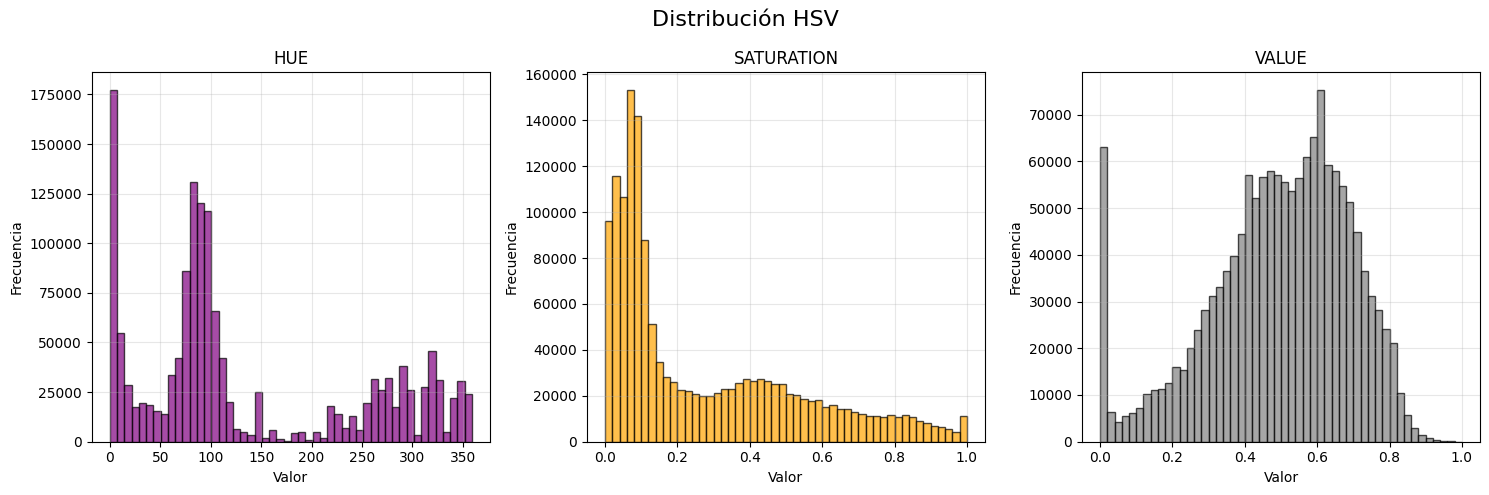


 Analizando distribución de brillo...


Calculando brillo:   0%|          | 0/30 [00:00<?, ?it/s]

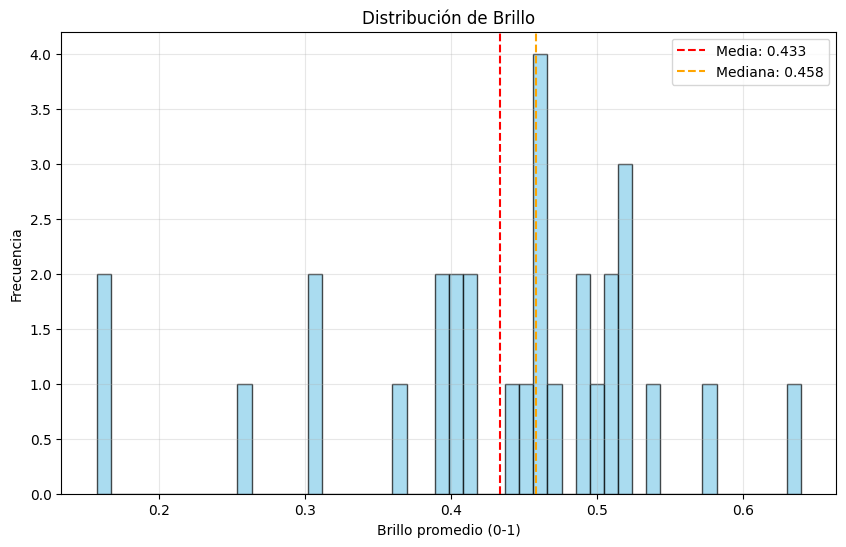


 Extrayendo colores dominantes...


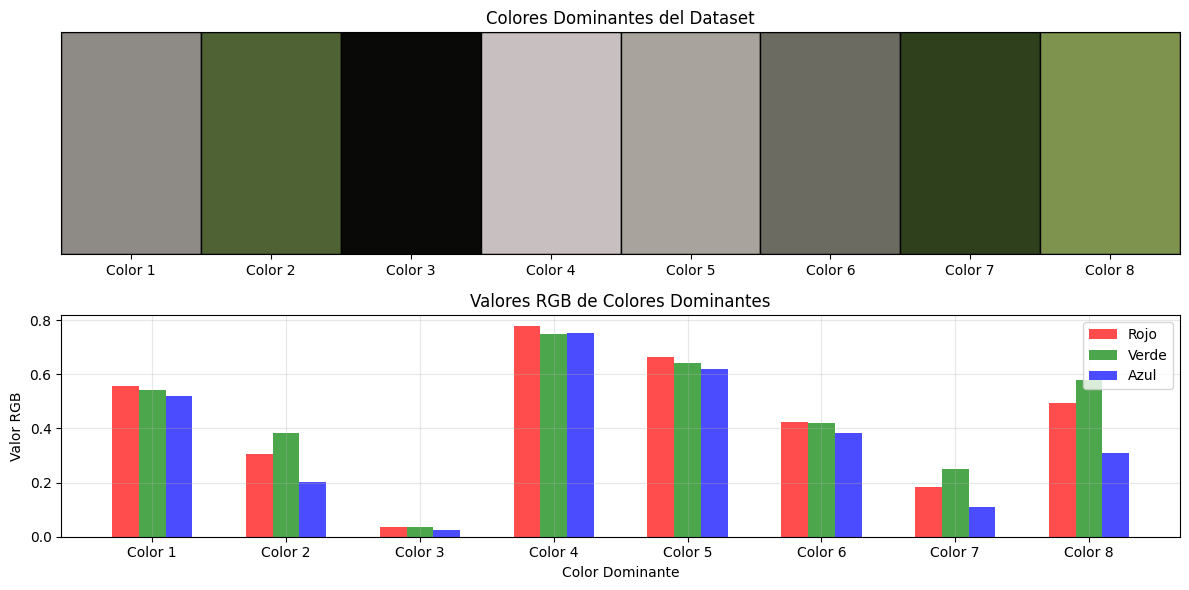

ESTADÍSTICAS DE DISTRIBUCIÓN DE COLORES

Canales RGB:
  RED: Media=0.447, Desv.Est=0.208, Min=0.000, Max=1.000
  GREEN: Media=0.469, Desv.Est=0.189, Min=0.000, Max=1.000
  BLUE: Media=0.384, Desv.Est=0.226, Min=0.000, Max=0.992

Canal dominante: GREEN

HSV:
  Matiz: Media=134.286
  Saturación: Media=0.271
  Valor: Media=0.492

Brillo:
  Media: 0.433
  Desviación: 0.107

Análisis de sesgos:
-> El Dataset tiene una distribución de brillo balanceada
-> El Dataset tiene colores DESATURADOS


In [11]:
plt.rcParams['figure.figsize'] = (12, 8)
IMGS_DIR = Path.cwd() / "plantvillage-dataset" / "color"
all_images = list(IMGS_DIR.rglob("*.jpg"))

def load_sample_images(n_samples=200):
    sample_df = random.sample(all_images, n_samples)
    images = []
    for img_name in tqdm(sample_df, total=len(sample_df), desc="Cargando imágenes"):
        try:
            img = Image.open(img_name).convert('RGB')
            img = img.resize((224, 224))  # Redimensionar para consistencia
            img_array = np.array(img) / 255.0  # Normalizar a [0, 1]
            images.append(img_array)
        except Exception as e:
            print(f"Error cargando folder={row['folder']}, name={row['name']}: {e}")
            continue
    
    print(f"Se cargaron {len(images)} imágenes de {len(all_images)} totales")
    return images

def analyze_rgb_distribution(images):
    rgb_values = {'red': [], 'green': [], 'blue': []}
    
    for img in tqdm(images, desc="Analizando RGB"):
        rgb_values['red'].extend(img[:, :, 0].flatten())
        rgb_values['green'].extend(img[:, :, 1].flatten())
        rgb_values['blue'].extend(img[:, :, 2].flatten())
    
    return rgb_values

def analyze_hsv_distribution(images):
    hsv_values = {'hue': [], 'saturation': [], 'value': []}
    
    for img in tqdm(images, desc="Analizando HSV"):
        img_hsv = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_RGB2HSV)
        hsv_values['hue'].extend(img_hsv[:, :, 0].flatten())
        hsv_values['saturation'].extend(img_hsv[:, :, 1].flatten())
        hsv_values['value'].extend(img_hsv[:, :, 2].flatten())
    
    return hsv_values

def calculate_brightness(images):
    brightness = []
    for img in tqdm(images, desc="Calculando brillo"):
        brightness.append(np.mean(img))
    return brightness

def extract_dominant_colors(images, k=8):
    sample_images = random.sample(images, min(20, len(images)))
    
    all_pixels = []
    for img in sample_images:
        pixels = img[::4, ::4, :].reshape(-1, 3)
        all_pixels.extend(pixels)
    
    # K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(all_pixels)
    
    return kmeans.cluster_centers_

def plot_rgb_histograms(rgb_values):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    colors = ['red', 'green', 'blue']
    
    for i, color in enumerate(colors):
        axes[i].hist(rgb_values[color], bins=50, color=color, alpha=0.7, edgecolor='black')
        axes[i].set_title(f'Canal {color.upper()}')
        axes[i].set_xlabel('Valor del pixel (0-1)')
        axes[i].set_ylabel('Frecuencia')
        axes[i].grid(True, alpha=0.3)
    
    plt.suptitle('Distribución de Canales RGB', fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_hsv_histograms(hsv_values):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    channels = ['hue', 'saturation', 'value']
    colors = ['purple', 'orange', 'gray']
    
    for i, (channel, color) in enumerate(zip(channels, colors)):
        axes[i].hist(hsv_values[channel], bins=50, color=color, alpha=0.7, edgecolor='black')
        axes[i].set_title(f'{channel.upper()}')
        axes[i].set_xlabel('Valor')
        axes[i].set_ylabel('Frecuencia')
        axes[i].grid(True, alpha=0.3)
    
    plt.suptitle('Distribución HSV', fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_brightness_histogram(brightness):
    plt.figure(figsize=(10, 6))
    plt.hist(brightness, bins=50, color='skyblue', alpha=0.7, edgecolor='black')
    plt.axvline(np.mean(brightness), color='red', linestyle='--', 
                label=f'Media: {np.mean(brightness):.3f}')
    plt.axvline(np.median(brightness), color='orange', linestyle='--', 
                label=f'Mediana: {np.median(brightness):.3f}')
    plt.title('Distribución de Brillo')
    plt.xlabel('Brillo promedio (0-1)')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_dominant_colors(colors):
    """Visualiza paleta de colores dominantes"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
    
    # Paleta visual
    for i, color in enumerate(colors):
        ax1.add_patch(plt.Rectangle((i, 0), 1, 1, facecolor=color, edgecolor='black'))
    
    ax1.set_xlim(0, len(colors))
    ax1.set_ylim(0, 1)
    ax1.set_title('Colores Dominantes del Dataset')
    ax1.set_xticks(np.arange(len(colors)) + 0.5)
    ax1.set_xticklabels([f'Color {i+1}' for i in range(len(colors))])
    ax1.set_yticks([])
    
    # Gráfico de barras RGB
    x = np.arange(len(colors))
    ax2.bar(x - 0.2, colors[:, 0], 0.2, label='Rojo', color='red', alpha=0.7)
    ax2.bar(x, colors[:, 1], 0.2, label='Verde', color='green', alpha=0.7)
    ax2.bar(x + 0.2, colors[:, 2], 0.2, label='Azul', color='blue', alpha=0.7)
    
    ax2.set_xlabel('Color Dominante')
    ax2.set_ylabel('Valor RGB')
    ax2.set_title('Valores RGB de Colores Dominantes')
    ax2.set_xticks(x)
    ax2.set_xticklabels([f'Color {i+1}' for i in range(len(colors))])
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def print_color_statistics(rgb_values, hsv_values, brightness):
    print("=" * 50)
    print("ESTADÍSTICAS DE DISTRIBUCIÓN DE COLORES")
    print("=" * 50)
    
    print("\nCanales RGB:")
    for channel in ['red', 'green', 'blue']:
        values = rgb_values[channel]
        print(f"  {channel.upper()}: Media={np.mean(values):.3f}, "
              f"Desv.Est={np.std(values):.3f}, Min={np.min(values):.3f}, Max={np.max(values):.3f}")
    
    rgb_means = [np.mean(rgb_values[ch]) for ch in ['red', 'green', 'blue']]
    dominant_channel = ['red', 'green', 'blue'][np.argmax(rgb_means)]
    print(f"\nCanal dominante: {dominant_channel.upper()}")
    
    print(f"\nHSV:")
    print(f"  Matiz: Media={np.mean(hsv_values['hue']):.3f}")
    print(f"  Saturación: Media={np.mean(hsv_values['saturation']):.3f}")
    print(f"  Valor: Media={np.mean(hsv_values['value']):.3f}")
    
    print(f"\nBrillo:")
    print(f"  Media: {np.mean(brightness):.3f}")
    print(f"  Desviación: {np.std(brightness):.3f}")
    
    print(f"\nAnálisis de sesgos:")
    if np.mean(brightness) < 0.3:
        print("-> El Dataset tiende hacia imágenes OSCURAS")
    elif np.mean(brightness) > 0.7:
        print("-> El Dataset tiende hacia imágenes CLARAS")
    else:
        print("-> El Dataset tiene una distribución de brillo balanceada")
    
    if np.mean(hsv_values['saturation']) < 0.3:
        print("-> El Dataset tiene colores DESATURADOS")
    elif np.mean(hsv_values['saturation']) > 0.7:
        print("-> El Dataset tiene colores MUY SATURADOS")
    else:
        print("-> El Dataset tiene saturación balanceada")

def analyze_color_distribution(n_samples=300):
    print("ANÁLISIS DE DISTRIBUCIÓN DE COLORES")
    print("=" * 40)
    print(f" Dataset: {len(all_images)} imágenes totales")
    print(f" Analizando muestra de: {min(n_samples, len(all_images))} imágenes")
    
    images = load_sample_images(n_samples)
    
    if len(images) == 0:
        print(" No se pudieron cargar imágenes")
        return
    
    print("\n Analizando distribución RGB...")
    rgb_values = analyze_rgb_distribution(images)
    plot_rgb_histograms(rgb_values)
    

    print("\n Analizando distribución HSV...")
    hsv_values = analyze_hsv_distribution(images)
    plot_hsv_histograms(hsv_values)
    
    print("\n Analizando distribución de brillo...")
    brightness = calculate_brightness(images)
    plot_brightness_histogram(brightness)
    
    print("\n Extrayendo colores dominantes...")
    dominant_colors = extract_dominant_colors(images)
    plot_dominant_colors(dominant_colors)
    
    print_color_statistics(rgb_values, hsv_values, brightness)
    


analyze_color_distribution(n_samples=30)

Algunas deducciones:
* Los canales Red y Green tienen una distribución razonablemente normal, mientras que el canal Blue tiene una asimetría hacia la izquierda. Tampoco es terrible, sigue teniendo forma acampanada, no es que es una exponencial.
* Las imágenes están en general bastante saturadas (seguramente hacia el verde), lo cuál es esperable.
* El brillo de las imágenes está demasiado distribuido, lo cuál no es bueno. Habría que uniformizar mmás el brillo.

## 2. Análisis de *bounding boxes*
En este caso, las imágenes no traen bounding boxes asociados

## 3. Análisis de distribución de etiquetas

Para esto, se puede trabajar con las cantidades de imágenes por conjunto de plantas, por enfermedades, etc. Este análisis está mas arriba, en la sección de creación del dataset.
Para el entrenamiento, se tendrá que elegir cuidadosamente el conjunto de datos para evitar sesgos.

## 4. Dimensión de imágenes y de radios de aspecto

Anchos:  256 (min), 256.0 (mediana), 470 (max)
Altos:   256 (min), 256.0 (mediana), 512 (max)


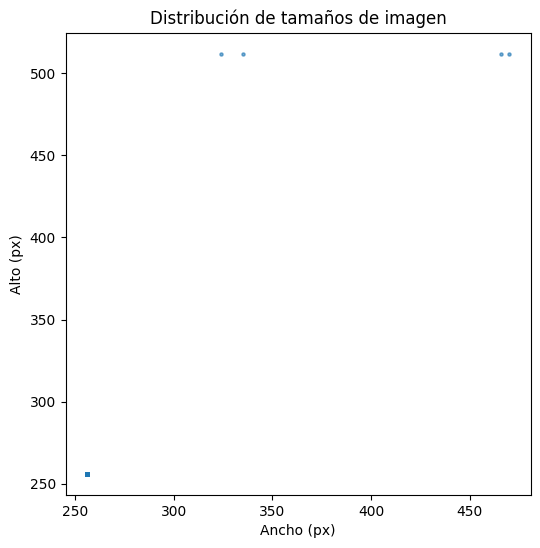

Aspect ratio: min= 0.6328125 mediana= 1.0 max= 1.0


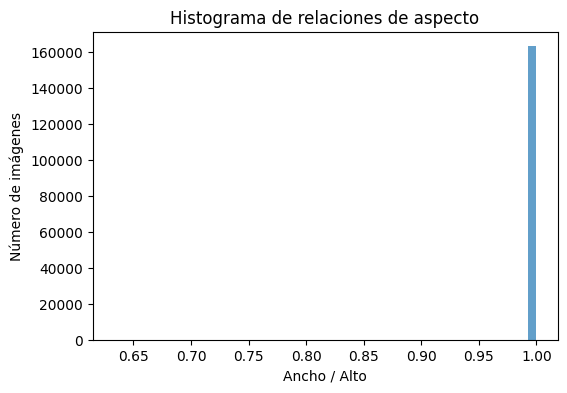

In [19]:
IMGS_DIR = Path.cwd() / "plantvillage-dataset"
sample_paths = list(IMGS_DIR.rglob("*.jpg"))
widths, heights = [], []
for p in sample_paths:
    img = Image.open(p)
    w, h = img.size
    widths.append(w)
    heights.append(h)


print("Anchos: ", np.min(widths), "(min),", np.median(widths), "(mediana),", np.max(widths), "(max)")
print("Altos:  ", np.min(heights), "(min),", np.median(heights), "(mediana),", np.max(heights), "(max)")

# Scatter de width vs height
plt.figure(figsize=(6,6))
plt.scatter(widths, heights, s=5, alpha=0.6)
plt.xlabel("Ancho (px)")
plt.ylabel("Alto (px)")
plt.title("Distribución de tamaños de imagen")
plt.show()

# Relación de aspecto
aspects = np.array(widths) / np.array(heights)
print("Aspect ratio: min=", np.min(aspects), "mediana=", np.median(aspects), "max=", np.max(aspects))

# Histograma de relaciones de aspecto
plt.figure(figsize=(6,4))
plt.hist(aspects, bins=50, alpha=0.7)
plt.xlabel("Ancho / Alto")
plt.ylabel("Número de imágenes")
plt.title("Histograma de relaciones de aspecto")
plt.show()


No se observan grandes variaciones en el radio de apecto, pero algunas imágenes son mayores que el estándar de 256x256

In [20]:
# Mostrar imágenes con valores superiores a la mediana
median_width = np.median(widths)
median_height = np.median(heights)
large_images = [sample_paths[i] for i in range(len(sample_paths)) 
               if widths[i] > median_width and heights[i] > median_height]

print(f"\nImágenes con ancho > {median_width:.0f} px y alto > {median_height:.0f} px:")
for img_path in large_images:
   print(img_path)


Imágenes con ancho > 256 px y alto > 256 px:
/home/gustavo/EDA_VpC2/plantvillage-dataset/segmented/Peach___Bacterial_spot/Rut._Bact.S 3430_final_masked.jpg
/home/gustavo/EDA_VpC2/plantvillage-dataset/segmented/Peach___Bacterial_spot/Rutg._Bact.S 1526_final_masked.jpg
/home/gustavo/EDA_VpC2/plantvillage-dataset/segmented/Tomato___Spider_mites Two-spotted_spider_mite/Com.G_SpM_FL 1378_final_masked.jpg
/home/gustavo/EDA_VpC2/plantvillage-dataset/segmented/Strawberry___Leaf_scorch/RS_L.Scorch 1161_final_masked.jpg


cómo las imágenes son pocas y solo son *imágenes segmentadas*, se las puede corregir o eliminar sin grandes pérdidas de datos.

In [21]:
# Eliminar de la lista all_images las rutas detectadas en large_images
all_images = [img for img in all_images if img not in large_images]

## 5. Calidad de imágenes

Para esto, analizaremos la medida de foco de la imagen, usando la función básica de la materia anterior: 

In [15]:
def metric_ismfd(img: np.ndarray) -> float:
    """Calculates the Image Sharpness Measure in Frequency Domain metric for a given image.

    Args:
        img (np.ndarray): Grayscale image of shape (m,n).

    Returns:
        float: Metric as calculated on the image.
    """

    # Following paper line-by-line
    f = np.fft.fft2(img)
    fc = np.fft.fftshift(f)
    af = np.abs(fc)
    m = af.max().item()

    th = np.sum(f > (m/1000))

    return th / img.size 

In [16]:
n_samples = 200
GRAY_IMGS_DIR = Path.cwd() / "plantvillage-dataset" / "grayscale"
all_images = list(GRAY_IMGS_DIR.rglob("*.jpg"))
sample_paths = random.sample(all_images, k=min(n_samples, len(all_images)))
ismfd_scores = []
for img_path in sample_paths:
    gray = np.array(Image.open(img_path))
    score = metric_ismfd(gray)
    ismfd_scores.append((img_path, score))

In [17]:
scores = np.array([s for _, s in ismfd_scores]).reshape(-1, 1)

# Ajustar KMeans con 2 clusters
km = KMeans(n_clusters=2, random_state=42).fit(scores)

# Obtener y ordenar los centros de los clusters
centers = sorted(km.cluster_centers_.flatten())
# Umbral = punto medio entre ambos centros
threshold = float(np.mean(centers))
print(f"Umbral ISMFD detectado por KMeans: {threshold:.6f}")

# Construir un DataFrame y clasificar
df = pd.DataFrame(ismfd_scores, columns=["path", "ismfd"])
df["blurred"] = df["ismfd"] < threshold

# Contar desenfocadas
n_total  = len(df)
n_blur   = df["blurred"].sum()
pct_blur = 100 * n_blur / n_total
print(f"Imágenes desenfocadas: {n_blur} / {n_total} ({pct_blur:.1f}%)")

Umbral ISMFD detectado por KMeans: 0.113883
Imágenes desenfocadas: 57 / 200 (28.5%)


Esto nos muestra que hay un gran conjunto de imágenes desenfocadas (e.g. con blur). Se debería usar algun método de mejoramiento de enfoque visto en la materia anterior cuando el valor ISMFD sea bajo.

## Exportar para continuar con el pipeline del procesamiento de imágenes en otra notebook

In [18]:
## transfer to csv for the next notebooks
pd.DataFrame(all_images, columns=["image_path"]).to_csv("all_images_clean.csv", index=False)
folder_df.to_csv("dataset_clean.csv", index=False)